**Author:** [Martina Cinquini](http://pages.di.unipi.it/cinquini/)  
**Python version:**  3.8 <br>
**Last update:** 11/22/21

# **NCDA** - **N**onlinear **C**ausal **D**iscovery with **Apriori**

### Table of Contents

* [Introduction to Causal Discovery (CD)](#section1)
    * [Nonlinear CD with Additive Noise Models](#section_1_1)
        * [Case 1: Bivariate Data](#section_1_1_1)
        * [Case 2: Multivariate Data](#section_1_1_2)
    * [Example Case 1](#section_1_2_1)
    * [Example Case 2](#section_1_2_2)
    * [Pros & Cons](#section_1_3)
* [Chapter 2](#chapter2)
    * [Section 2.1](#section_2_1)
    * [Section 2.2](#section_2_2)
    * [Section 1.2.3](#section_1_2_3)

### Introduction to Causal Discovery <a class="anchor" id="section1"></a>

Given a dataset $X$, the objective of causal discovery is to infer as much as possible about the mechanism generating the data. In particular, the goal is to discover the graph $G$ modeling the dependencies among variables.
<br><br>
<div>
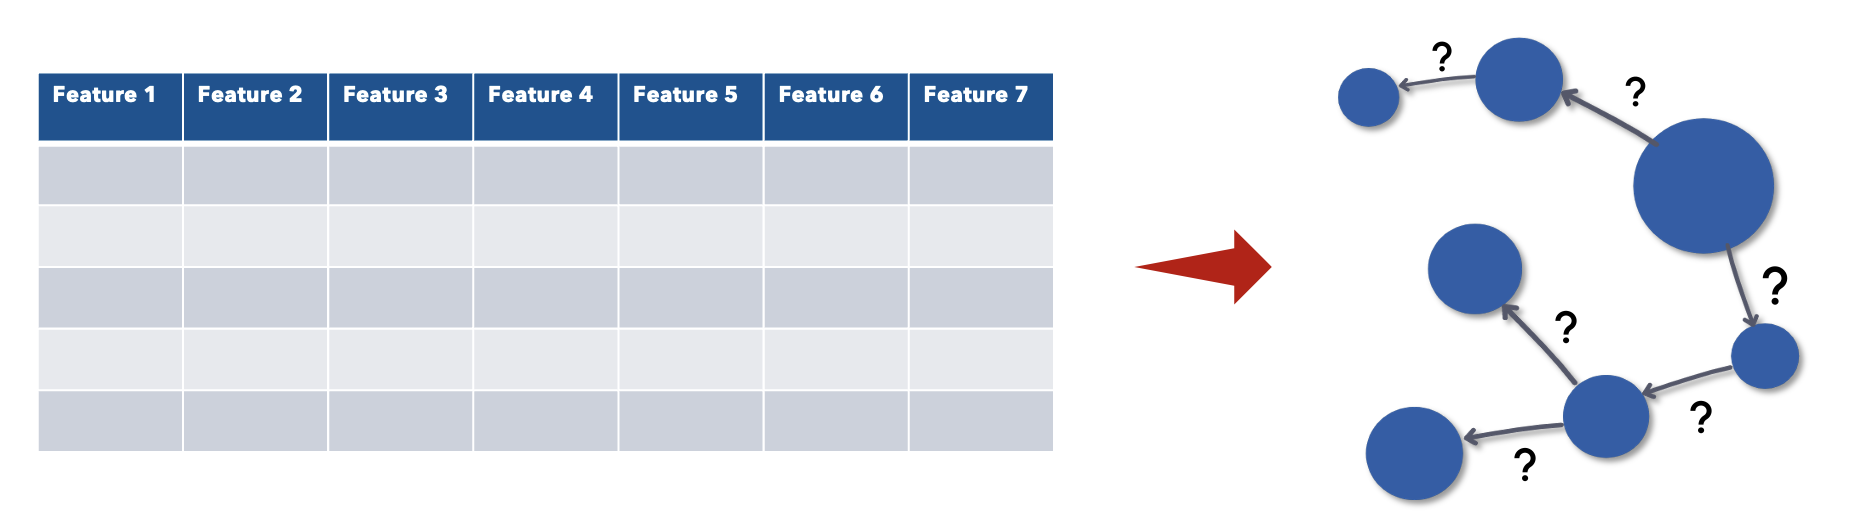
</div>

#### Nonlinear CD with additive noise models<a class="anchor" id="section1_1"></a>
As starting point for our project we adopt a specific procedure called [Nonlinear Causal Discovery (NCD)](https://papers.nips.cc/paper/2008/file/f7664060cc52bc6f3d620bcedc94a4b6-Paper.pdf) originally proposed by
Hoyer et al. that demonstrates that nonlinearities in the data generation process allow more accurate information of the causal system to be identified.

They assume that the observed data has been generated in the following way:
<br>
each feature $x^{(j)}$ is associated with a node $j$ in $G$, and the values of $x^{(j)}$ are obtained as a function of its parents in $G$, plus some independent additive noise $\nu^{(j)}$, i.e., <br>
<br>
\begin{equation}
\label{eq:hoyer}
    x^{(j)} = f_j(\mathit{pa}(j)) + \nu^{(j)}
\end{equation}
<br>
where $f_j$ is an arbitrary function (possibly different for each $j$), $\mathit{pa}(j)$ is a vector containing the elements $x^{(j)}$ such that there is an edge from $i$ to $j$ in $G$, i.e., $\mathit{pa}(j)$ returns the parents of $j$.

#### Case 1: Bivariate Data<a class="anchor" id="section1_1_1"></a>

We now consider practical estimation method which infer the generating graph from sample data. 

1) Test whether x and y are statistically independent. 
<br>If they are not, we continue as described in the following manner: <br> <br>
2) Test whether a model $y:=f(x) + n$ is consistent with the data <br>
    - By doing a nonlinear regression of y on x (to get an estimate $\hat{f}$ of $f$) <br>
    - Calculating the corresponding residuals $\hat{n} = y − f(x)$ <br>
    - Testing whether $\hat{n}$ is independent of x. <br> <br>
3) If $\hat{n}$ is independent of x, we accept the model $y := f(x) + n$; if not, we reject it. <br>

4) We then similarly test whether the reverse model $x := g(y) + n$ fits the data.

#### Case 2: Multivariate Data<a class="anchor" id="section1_1_2"></a>

For each DAG, test whether it is consistent with the data by constructing a **nonlinear regression of each variable on its parents** and subsequently testing whether the **resulting residuals are mutually independent**. <br> <br>
The DAG is accepted only **if none of the independence tests are rejected**. 

### Example Case 1 - Abalone Dataset<a class="anchor" id="section1_2_1"></a>

In [16]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
from time import time

Let's analyze a possible application of the methodology. The object of investigation is an open-source dataset from the UCI repository concerning the [abalone](https://archive.ics.uci.edu/ml/datasets/abalone), a group of shellfish.

In [2]:
directory = os.path.realpath(os.path.dirname("GENCDA"))
file_path = os.path.join(os.path.dirname(directory), "datasets", "abalone.csv")
dataset = pd.read_csv(file_path) # Abalone Data
df = dataset.sample(500) # Sample of 500 instances
df.head()

,Rings,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
1024,10,0.645,0.500,0.155,1.2205,0.6145,0.2360,0.3185
1629,10,0.570,0.430,0.145,0.8330,0.3540,0.1440,0.2815
1152,8,0.590,0.470,0.150,0.9955,0.4810,0.2320,0.2400
514,5,0.275,0.195,0.070,0.0800,0.0310,0.0215,0.0250
4115,10,0.605,0.465,0.155,1.1000,0.5470,0.2665,0.2585


Ground Truth


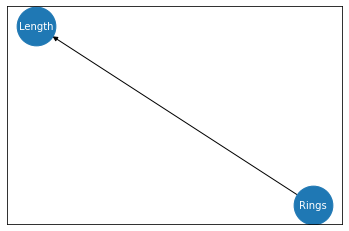

In [3]:
import networkx as nx
graph = nx.DiGraph()
graph.add_edges_from([('Rings', 'Length')])
print('Ground Truth')
nx.draw_networkx(graph, node_size=1500, font_color='w', font_size=10)

Specifically, variables considered are:
* The number of rings in the abalone shell that indicate their age
* The length of the shell

In [4]:
from causal_discovery.hoyer import *

In [12]:
# To run causal discovery, we create a NonlinearANM object                                                                                          1e-10, 1e+1))
obj = NonlinearANM(df) 

index_rings = 0
index_length = 1

# We specify the covariance function of the regressor
kernel = 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

# Finally, we call the fit method for the case of two variables 
p_value_general, p_value_fm, p_value_bm = obj.fit_bivariate(index_rings, index_length, kernel=kernel)

In [13]:
obj.evaluate(p_value_general, p_value_fm, p_value_bm)

Rings causes Length


Forward Model (Rings , Length)


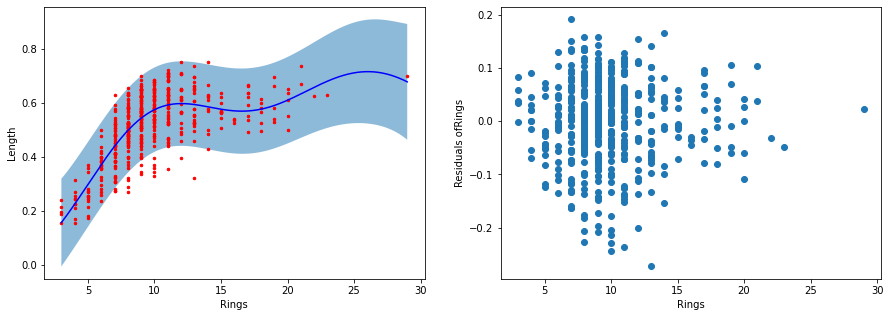

Backward Model (Length , Rings)


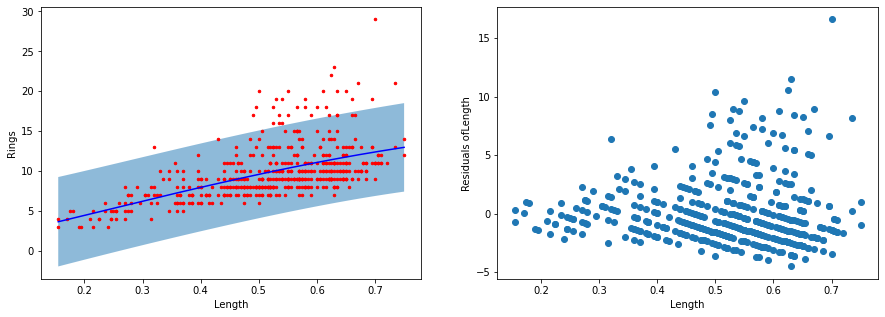

In [14]:
obj.show_plots()

### Example Case 2 - Synthetic Dataset<a class="anchor" id="section1_2_2"></a>

In [20]:
# Experiment on synthetic data used in the paper
np.random.seed(1)
n = 1000
nx = uniform(-1, 1, n)
ny = uniform(-1, 1, n)
nz = uniform(-1, 1, n)
w = uniform(-3, 3, n)
x = w ** 2 + nx
y = 4 * np.sqrt(np.absolute(w)) + ny
z = 2 * np.sin(x) + 2 * np.sin(y) + nz

matrix = np.column_stack((w, x, y, z))
feature_names = ['w', 'x', 'y', 'z']

synthetic_data = pd.DataFrame(matrix, columns=feature_names)

In [21]:
# We create a NonlinearANM object
obj2 = NonlinearANM(synthetic_data)

# Parameters of the fit_multivariate method
alpha = 0.02
percentage_split = 0.7
dag_sorting_type = np.min

start_time = time()

possible_dags = obj2.fit_multivariate(alpha, percentage_split, dag_sorting_type)

nonlinearANM_execution_time = time() - start_time


KeyboardInterrupt: 

In [ ]:
ordered_result = sorted(possible_dags, key=itemgetter(1), reverse=True)

In [ ]:
res = []
for adj_matrix, p_value in possible_dags:
    res.append(adj_matrix)
show_dependency(res, feature_names)